In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import shap
shap.initjs()


In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,721,G2,13,8.20
1,C,1_49,F,40-49,334,G2,0,2.51
2,M,50_249,F,40-49,522,G2,18,2.19
3,M,50_249,F,40-49,522,G2,12,2.19
4,M,50_249,F,14-29,522,G2,0,2.19


In [3]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:',
    'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


In [4]:
y_train_mean = np.mean(y_train)
y_train_mean

4.914103928927119

# Model and predictions

## Initial model

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ]
)

model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])
#model = make_pipeline(preprocessor, XGBRegressor())
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              co...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [6]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

y_train_mean = np.mean(y_train)


Train: RMSE= 1.425  R2= 0.687
Test: RMSE= 1.651  R2= 0.578


## Randomized Search CV

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])

grid = {'regr__max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 11],
        'regr__eta': np.linspace(0.05, 0.35, 30),
        'regr__gamma': np.linspace(1,  3,  9),
        'regr__min_child_weight': [3, 4, 5, 6],
        'regr__subsample': np.linspace(0.3, 1, 9), # best 1 (default)
        'regr__colsample_bytree': [0.7, 0.8, 0.9],
        'regr__alpha': [0, 0.5, 1], # best 1 (default)
        'regr__lambda' : [1, 5, 10, 20], # best 1 (default)
        'regr__learning_rate': [0.05, 0.1, 0.2]
         }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 100, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)
results.best_params_

{'regr__subsample': 0.825,
 'regr__min_child_weight': 3,
 'regr__max_depth': 10,
 'regr__learning_rate': 0.2,
 'regr__lambda': 20,
 'regr__gamma': 2.25,
 'regr__eta': 0.08103448275862069,
 'regr__colsample_bytree': 0.8,
 'regr__alpha': 0}

In [8]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(alpha=0, base_score=0.5, booster='gbtree',
                              callbacks...
                              enable_categorical=False, eta=0.08103448275862069,
                              eval_metric=None, feature_types=None, gamma=2.25,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              lambda=20, learning_rate=0.2, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=10, max_leaves=0,
                              min_child_weight=3, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, ...))])

In [9]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.416  R2= 0.69
Test: RMSE= 1.644  R2= 0.581


## Feature importance
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

https://mljar.com/blog/feature-importance-xgboost/


### XGBoost

In [10]:
best_regr = best_model.named_steps["regr"]
feature_importances = best_regr.feature_importances_

prep = best_model.named_steps["prep"]
feature_names = prep.get_feature_names_out()

importances = pd.DataFrame({'importance': feature_importances }, index=feature_names )
importances.sort_values('importance', ascending=False)

,importance
categorical__lpk_251,0.089290
categorical__education_G1,0.081823
categorical__education_G2,0.081499
categorical__lpk_122,0.035567
categorical__lpk_133,0.031438
...,...
categorical__lpk_263,0.001219
categorical__lpk_831,0.001117
categorical__lpk_235,0.001031
categorical__lpk_732,0.000918


### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


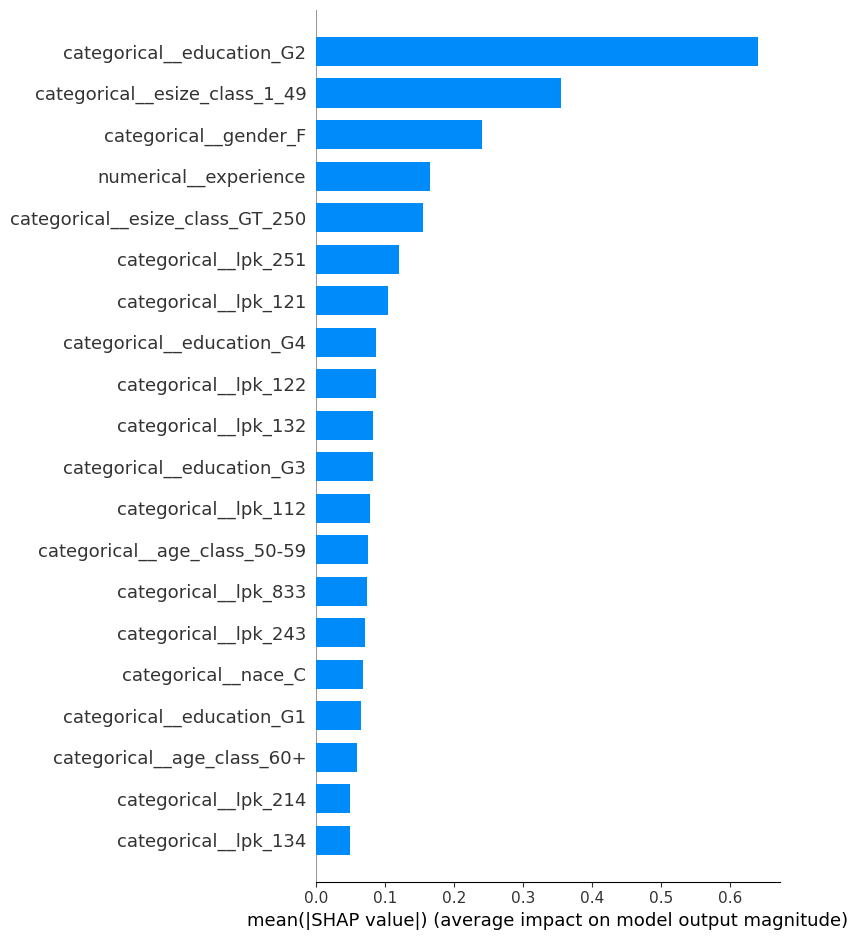

In [11]:
explainer = shap.TreeExplainer(best_regr, feature_names=feature_names)
shap_values = explainer(prep.transform(X_test))
shap.summary_plot(shap_values, plot_type="bar");

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


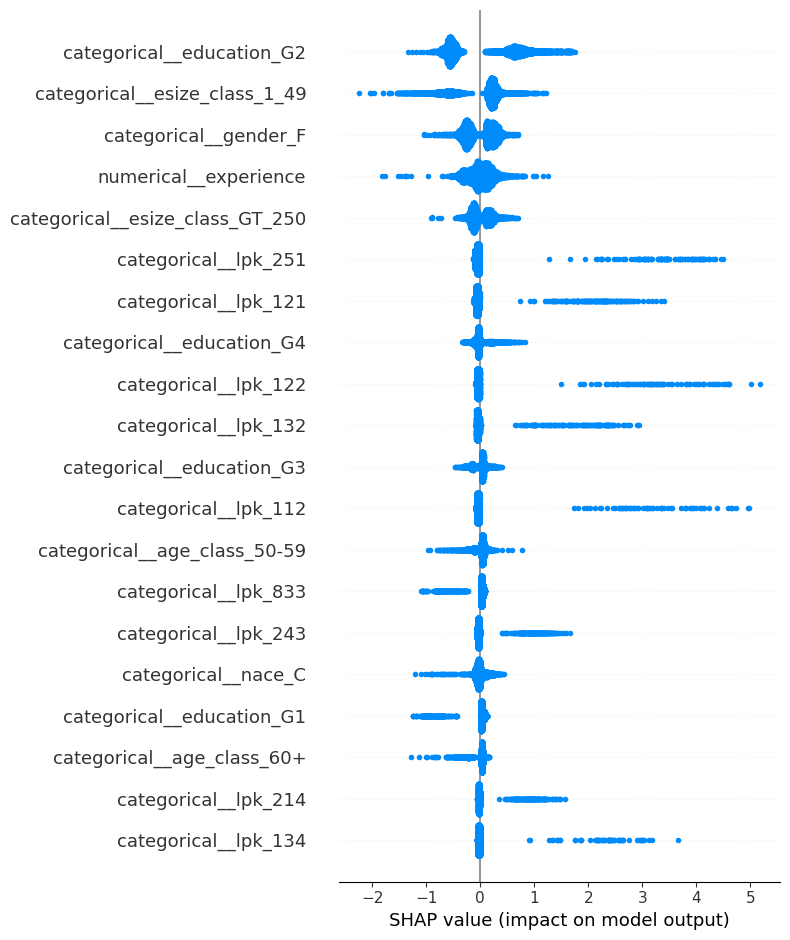

In [12]:
shap_values = shap.TreeExplainer(best_model['regr']).shap_values(prep.transform(X_test))
shap.summary_plot(shap_values, feature_names=feature_names, );

# Model (Pipline) Serialization 

In [21]:
import joblib
joblib.dump(best_model, './Models/XGBoost_model.joblib')

['./Models/XGBoost_model.joblib']